In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

In [2]:
import numpy as np


class ObjectLevelMetrics:

    def __init__(self):
        self.reward_sum = 0
        self.n_episodes = 0
        self.n_steps = 0

    def reset(self):
        self.reward_sum = 0
        self.n_episodes = 0
        self.n_steps = 0

    def __call__(self, obs, reward, done, info):
        self.n_steps += np.size(reward)
        self.reward_sum += np.sum(reward)
        self.n_episodes += np.sum(done)

    def get_results(self):
        return {
            'ObjectLevelMeanReward': self.reward_sum / max(1, self.n_episodes),
            'ObjectLevelMeanStepsPerEpisode': self.n_steps / max(1, self.n_episodes),
            'ObjectLevelEpisodes': self.n_episodes
        }

In [3]:
object_level_metrics = ObjectLevelMetrics()

args = {
    'pretrained_runs_folder': 'runs',
    'pretrained_run': 'run-16823527592836354',
    'pretrained_percentile': 0.75,
    'expand_all_actions': True,
    'collect_steps_per_iteration': 16,
    'finish_on_terminate': True,
    'object_level_transition_observers': [object_level_metrics]
}

In [4]:
from mlrl.experiments.procgen_meta import create_batched_procgen_meta_envs, load_pretrained_q_network

pygame 2.1.0 (SDL 2.0.16, Python 3.8.10)
Hello from the pygame community. https://www.pygame.org/contribute.html
Using TensorFlow 2.9.0
Using TensorFlow 2.9.0
8 Physical GPUs, 6 Logical GPU


In [7]:
object_config = load_pretrained_q_network(
    folder=args['pretrained_runs_folder'],
    run=args['pretrained_run'],
    percentile=args.get('pretrained_percentile', 0.75),
    verbose=False
)

batched_meta_env = create_batched_procgen_meta_envs(n_envs=16, object_config=object_config, **args)

In [5]:
from mlrl.runners.eval_runner import EvalRunner
from mlrl.meta.meta_policies.a_star_policy import AStarPolicy
from mlrl.meta.meta_policies.random_policy import create_random_search_policy, create_random_search_policy_no_terminate
from mlrl.meta.meta_policies.terminator_policy import TerminatorPolicy

In [10]:
object_level_metrics.reset()

eval_runner = EvalRunner(
    1000, batched_meta_env, AStarPolicy(batched_meta_env),
    rewrite_rewards=True,
    use_tf_function=False
)

In [11]:
eval_runner.run()

1008/1000 [==============================] - 91s 90ms/step - AverageReturn: 0.2180
Evaluation stats:
EvalRewrittenAverageReturn: 0.103, EvalFinalPolicyValue: 25.034, EvalNumberOfEpisodes: 336.000, EvalEnvironmentSteps: 1008.000, EvalAverageReturn: 0.313, EvalAverageEpisodeLength: 3.000, EvalTime: 91.288


{'EvalRewrittenAverageReturn': 0.102711245,
 'EvalFinalPolicyValue': 25.034240086470305,
 'EvalNumberOfEpisodes': 336,
 'EvalEnvironmentSteps': 1008,
 'EvalAverageReturn': 0.31277207,
 'EvalAverageEpisodeLength': 3.0,
 'EvalTime': 91.28831720352173}

In [12]:
object_level_metrics.get_results()

{'MeanReward': 24.0, 'MeanStepsPerEpisode': 336.0, 'Episodes': 1}

In [9]:
object_level_metrics.reset()
object_level_metrics.get_results()

{'MeanReward': 0.0, 'MeanStepsPerEpisode': 0.0, 'Episodes': 0}

In [6]:
from typing import Dict

import pandas as pd


def test_policies_with_pretrained_model(policy_creators: Dict[str, callable],
                                        percentile=0.75,
                                        eval_steps_per_env=1000,
                                        n_envs=16):

    object_level_metrics = ObjectLevelMetrics()

    args = {
        'pretrained_runs_folder': 'runs',
        'pretrained_run': 'run-16823527592836354',
        'pretrained_percentile': percentile,
        'expand_all_actions': True,
        'finish_on_terminate': True,
        'object_level_transition_observers': [object_level_metrics]
    }

    object_config = load_pretrained_q_network(
        folder=args['pretrained_runs_folder'],
        run=args['pretrained_run'],
        percentile=args.get('pretrained_percentile', 0.75),
        verbose=False
    )


    results = []
    for policy_name, create_policy in policy_creators.items():

        batched_meta_env = create_batched_procgen_meta_envs(n_envs=n_envs, object_config=object_config, **args)

        eval_runner = EvalRunner(
            eval_steps_per_env * n_envs, batched_meta_env, create_policy(batched_meta_env),
            rewrite_rewards=True,
            use_tf_function=False
        )

        print(f'Evaluating {policy_name}')
        object_level_metrics.reset()
        eval_results = eval_runner.run()
        object_level_results = object_level_metrics.get_results()

        results.append({
            'Meta-level Policy': policy_name,
            **args,
            **object_config,
            **eval_results,
            **object_level_results
        })
    
    return results

In [7]:
policy_creators = {
    'AStar': AStarPolicy,
    'Random': create_random_search_policy,
    'RandomNoTerminate': create_random_search_policy_no_terminate,
    'Terminator': TerminatorPolicy
}

evaluations = []
for percentile in [0.25, 0.5, 0.75, 0.9]:
    print(f'Evaluating with pretrained model at return {percentile = }')
    evaluations += test_policies_with_pretrained_model(policy_creators, percentile=percentile, eval_steps_per_env=250)

Evaluating with pretrained model at return percentile = 0.25
Evaluating AStar
4000/4000 [==============================] - 369s 92ms/step - AverageReturn: 0.2133
Evaluation stats:
EvalFinalPolicyValue: 17.920, EvalTime: 368.729
Evaluating Random
4001/4000 [==============================] - 264s 66ms/step - AverageReturn: 0.0757
Evaluation stats:
EvalFinalPolicyValue: 18.019, EvalTime: 263.875
Evaluating RandomNoTerminate
4006/4000 [==============================] - 272s 68ms/step - AverageReturn: 0.0694
Evaluation stats:
EvalFinalPolicyValue: 17.890, EvalTime: 271.710
Evaluating Terminator
4000/4000 [==============================] - 42s 10ms/step - AverageReturn: 0.0000e+00
Evaluation stats:
EvalTime: 41.966
Evaluating with pretrained model at return percentile = 0.5
Evaluating AStar
4000/4000 [==============================] - 371s 93ms/step - AverageReturn: 0.3194
Evaluation stats:
EvalFinalPolicyValue: 21.659, EvalTime: 371.148
Evaluating Random
4007/4000 [=========================

In [14]:
evaluations_df = pd.DataFrame(evaluations)
evaluations_df

,Meta-level Policy,pretrained_runs_folder,pretrained_run,pretrained_percentile,expand_all_actions,finish_on_terminate,object_level_transition_observers,action_repeats,agent_name,collect_steps_per_iteration,...,pretrained_path,EvalRewrittenAverageReturn,EvalNumberOfEpisodes,EvalEnvironmentSteps,EvalAverageReturn,EvalAverageEpisodeLength,EvalTime,ObjectLevelMeanReward,ObjectLevelMeanStepsPerEpisode,ObjectLevelEpisodes
0,Terminator,runs,run-16823527592836354,0.25,True,True,[<__main__.ObjectLevelMetrics object at 0x7efd...,4,categorical_dqn_agent,1,...,runs/categorical_dqn_agent/run-168235275928363...,0.0,1600,1600,0.0,1.0,16.908429,17.000000,160.000000,10
1,Terminator,runs,run-16823527592836354,0.50,True,True,[<__main__.ObjectLevelMetrics object at 0x7efc...,4,categorical_dqn_agent,1,...,runs/categorical_dqn_agent/run-168235275928363...,0.0,1600,1600,0.0,1.0,16.932898,32.000000,400.000000,4
2,Terminator,runs,run-16823527592836354,0.75,True,True,[<__main__.ObjectLevelMetrics object at 0x7efd...,4,categorical_dqn_agent,1,...,runs/categorical_dqn_agent/run-168235275928363...,0.0,1600,1600,0.0,1.0,16.420366,9.083333,133.333333,12
3,Terminator,runs,run-16823527592836354,0.90,True,True,[<__main__.ObjectLevelMetrics object at 0x7efb...,4,categorical_dqn_agent,1,...,runs/categorical_dqn_agent/run-168235275928363...,0.0,1600,1600,0.0,1.0,16.777731,15.090909,145.454545,11


In [15]:
evaluations_df.columns

Index(['Meta-level Policy', 'pretrained_runs_folder', 'pretrained_run',
       'pretrained_percentile', 'expand_all_actions', 'finish_on_terminate',
       'object_level_transition_observers', 'action_repeats', 'agent_name',
       'collect_steps_per_iteration', 'discount', 'env', 'epsilon',
       'epsilon_decay_steps', 'epsilon_schedule', 'eval_steps',
       'experience_batch_size', 'final_epsilon', 'frame_stack', 'grayscale',
       'initial_collect_steps', 'initial_epsilon', 'learning_rate',
       'max_epochs', 'metrics', 'model_config', 'n_collect_envs',
       'n_eval_envs', 'n_video_envs', 'name', 'optimiser_config',
       'procgen_env_name', 'replay_buffer_capacity', 'run_dir',
       'target_network_update_period', 'train_steps_per_epoch',
       'video_seconds', 'pretrained_epoch', 'pretrained_return',
       'pretrained_path', 'EvalRewrittenAverageReturn', 'EvalNumberOfEpisodes',
       'EvalEnvironmentSteps', 'EvalAverageReturn', 'EvalAverageEpisodeLength',
       'EvalT

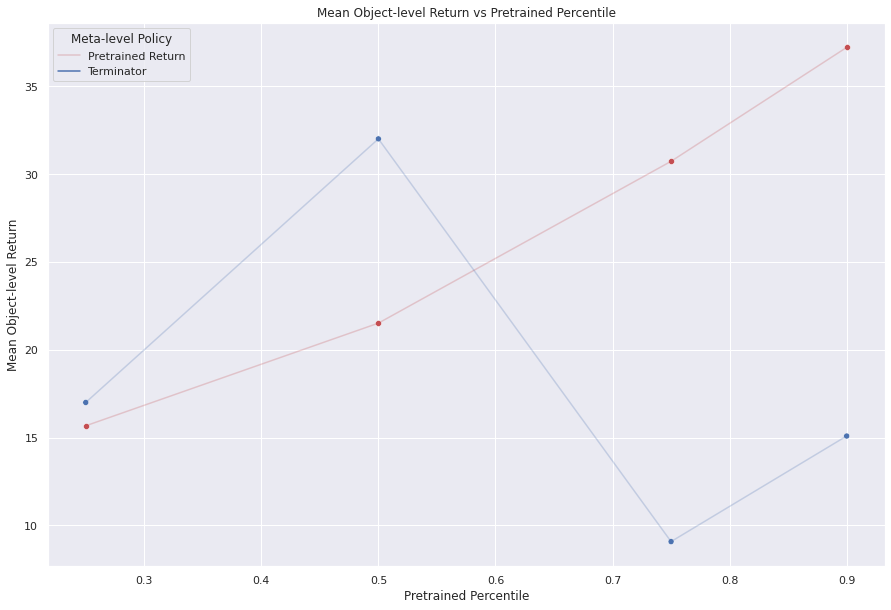

In [19]:
plots = {
    'Mean Object-level Return': 'ObjectLevelMeanReward',
    # 'Mean Object-level Steps Per Episode': 'ObjectLevelMeanStepsPerEpisode',
    # 'Object-level Episodes': 'ObjectLevelEpisodes',
}

for plot_name, plot_key in plots.items():
    plt.figure(figsize=(15, 10))

    sns.lineplot(data=evaluations_df, x='pretrained_percentile', y='pretrained_return', label='Pretrained Return', alpha=0.25, color='r')
    sns.lineplot(data=evaluations_df, x='pretrained_percentile', y=plot_key, hue='Meta-level Policy', alpha=0.25)

    sns.scatterplot(data=evaluations_df, x='pretrained_percentile', y='pretrained_return', color='r', legend=False)
    sns.scatterplot(data=evaluations_df, x='pretrained_percentile', y=plot_key, hue='Meta-level Policy', legend=False)

    plt.xlabel('Pretrained Percentile')
    plt.ylabel(plot_name)
    plt.title(f'{plot_name} vs Pretrained Percentile')
    plt.show()

In [13]:
from mlrl.utils.render_utils import embed_mp4

object_level_metrics.reset()
embed_mp4(eval_runner.create_policy_eval_video(60))

In [15]:
object_level_metrics.get_results()

{'MeanReward': 0.0, 'MeanStepsPerEpisode': 30.0, 'Episodes': 0}